# imports

In [27]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from data_viz_functions import *

random_seed = 42

# reading data

In [28]:
DATA_DIR = 'kaggle/input'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# preprocessing

In [29]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [30]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [31]:
# Заподнение пропускоы в ['education'] наиболее частым значением 'SCH'
data["education"].fillna(data.education.mode(), inplace=True)

In [32]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [33]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [34]:
data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)

In [35]:
# Нормализация численных данных
for column in num_cols:
    data[column] = StandardScaler().fit_transform(np.array(data[column].values).reshape(-1, 1))

In [36]:
data.sample(5, random_state=random_seed).T

,74834,17526,75682,26882,28861
sex,0.000000,1.000000,0.000000,0.000000,1.000000
age,-1.130811,-0.773745,1.362924,-0.347997,-1.007707
car,0.000000,1.000000,0.000000,1.000000,0.000000
car_type,0.000000,1.000000,0.000000,0.000000,0.000000
decline_app_cnt,-0.418815,-0.418815,-0.418815,-0.418815,-0.418815
good_work,0.000000,0.000000,0.000000,0.000000,0.000000
score_bki,0.368124,-0.250086,-1.383239,0.317360,-0.992421
bki_request_cnt,1.109345,-1.334144,-1.334144,-0.281790,-0.281790
region_rating,6.000000,4.000000,3.000000,3.000000,3.000000
home_address,1.000000,1.000000,0.000000,0.000000,1.000000


# undersampling

In [37]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [38]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [39]:
# undersampling

rus = RandomUnderSampler(random_state=random_seed)
X_us, y_us = rus.fit_resample(X, y)


X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
    X_us, y_us, test_size=0.10, shuffle=True, random_state=random_seed
)

# simple model

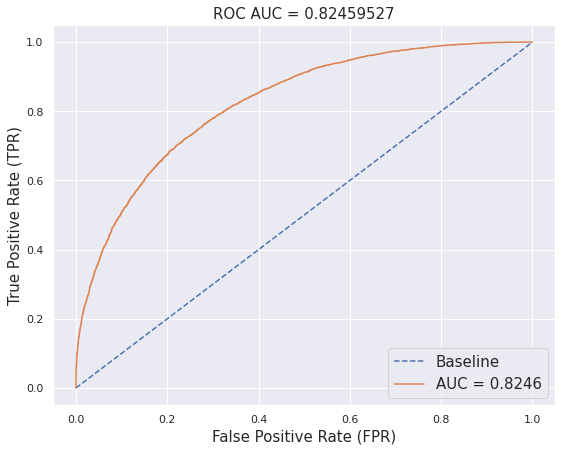

In [40]:
plot_roc_auc(
    y_train_us,
    CatBoostClassifier(silent=True)
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

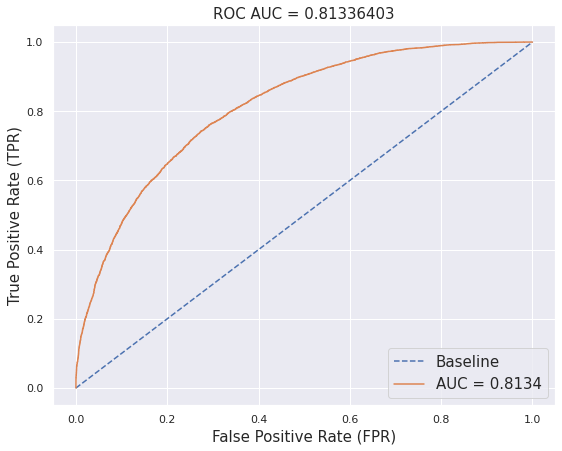

In [41]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

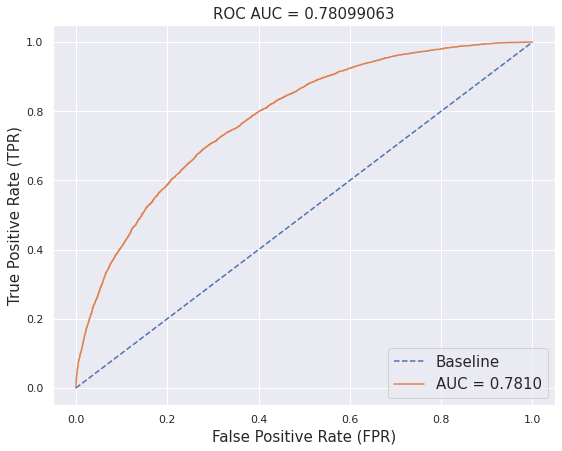

In [42]:
plot_roc_auc(
    y_train_us,
    HistGradientBoostingClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

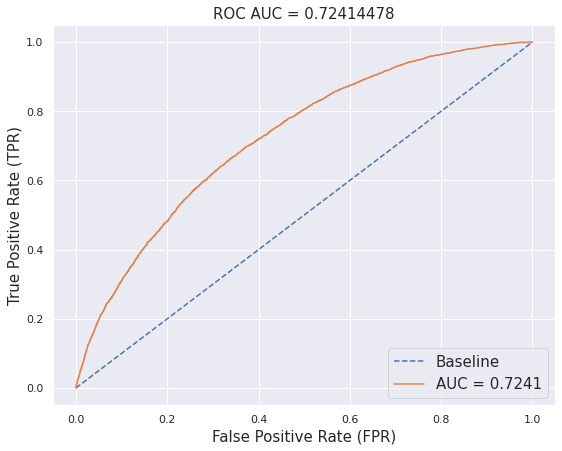

In [43]:
plot_roc_auc(
    y_train_us,
    LogisticRegression(solver="saga", max_iter=1000, random_state=random_seed) # уже хорошо отгридсёрченная в бейзлайне
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)


# parameter tuning

In [44]:
import optuna


def objective(trial):

    from sklearn.model_selection import cross_val_score

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = LGBMClassifier(**param)
    cv_roc_auc = cross_val_score(gbm, X_us, y_us, cv=8, scoring="roc_auc", n_jobs=-1)

    score = np.min(cv_roc_auc)
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=600, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2021-12-19 10:03:26,048] A new study created in memory with name: no-name-31b8ff6e-6011-412f-b0ff-767a17fa79c5


[LightGBM] [Warning] bagging_fraction is set=0.8533789404034275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8533789404034275
[LightGBM] [Warning] lambda_l1 is set=1.957285197217555e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.957285197217555e-05
[LightGBM] [Warning] feature_fraction is set=0.8924999223607206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8924999223607206
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.572365942330599e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.572365942330599e-05
[LightGBM] [Warning] bagging_fraction is set=0.8533789404034275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8533789404034275
[LightGBM] [Warning] lambda_l1 is set=1.957285197217555e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.957285197217555e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:03:30,780] Trial 0 finished with value: 0.7125353028099434 and parameters: {'lambda_l1': 1.957285197217555e-05, 'lambda_l2': 6.572365942330599e-05, 'num_leaves': 18, 'feature_fraction': 0.8924999223607206, 'bagging_fraction': 0.8533789404034275, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.9670113503345702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670113503345702
[LightGBM] [Warning] lambda_l1 is set=4.0085957219478905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0085957219478905
[LightGBM] [Warning] feature_fraction is set=0.5354998050410823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354998050410823
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00012592381046050874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012592381046050874
[LightGBM] [Warning] bagging_fraction is set=0.9670113503345702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670113503345702
[LightGBM] [Warning] lambda_l1 is set=4.0085957219478905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0085957219478905
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:03:34,302] Trial 1 finished with value: 0.7098407766763917 and parameters: {'lambda_l1': 4.0085957219478905, 'lambda_l2': 0.00012592381046050874, 'num_leaves': 67, 'feature_fraction': 0.5354998050410823, 'bagging_fraction': 0.9670113503345702, 'bagging_freq': 2, 'min_child_samples': 78}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.8456078998351086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456078998351086
[LightGBM] [Warning] bagging_fraction is set=0.8456078998351086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456078998351086
[LightGBM] [Warning] lambda_l1 is set=2.367769774963123e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.367769774963123e-08
[LightGBM] [Warning] feature_fraction is set=0.7356007371332481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7356007371332481
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.18594732945726133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18594732945726133
[LightGBM] [Warning] lambda_l1 is set=2.367769774963123e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.367769774963123e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:03:36,817] Trial 2 finished with value: 0.7012041573521655 and parameters: {'lambda_l1': 2.367769774963123e-08, 'lambda_l2': 0.18594732945726133, 'num_leaves': 85, 'feature_fraction': 0.7356007371332481, 'bagging_fraction': 0.8456078998351086, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.49670800163987866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49670800163987866
[LightGBM] [Warning] lambda_l1 is set=0.04048520598024756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04048520598024756
[LightGBM] [Warning] feature_fraction is set=0.9040612378223294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9040612378223294
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.3552722722900232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3552722722900232
[LightGBM] [Warning] bagging_fraction is set=0.49670800163987866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49670800163987866
[LightGBM] [Warning] lambda_l1 is set=0.04048520598024756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04048520598024756
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:03:41,317] Trial 3 finished with value: 0.6891210511129311 and parameters: {'lambda_l1': 0.04048520598024756, 'lambda_l2': 2.3552722722900232, 'num_leaves': 163, 'feature_fraction': 0.9040612378223294, 'bagging_fraction': 0.49670800163987866, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.5813336188560307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813336188560307
[LightGBM] [Warning] lambda_l1 is set=1.1412660658540316e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1412660658540316e-07[LightGBM] [Warning] bagging_fraction is set=0.5813336188560307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813336188560307
[LightGBM] [Warning] lambda_l1 is set=1.1412660658540316e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1412660658540316e-07
[LightGBM] [Warning] feature_fraction is set=0.880977102083669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880977102083669
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.969120015296927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.969120015296927
[LightGBM] [Warning] bagging_frac

[I 2021-12-19 10:03:45,377] Trial 4 finished with value: 0.6958376930542722 and parameters: {'lambda_l1': 1.1412660658540316e-07, 'lambda_l2': 2.969120015296927, 'num_leaves': 123, 'feature_fraction': 0.880977102083669, 'bagging_fraction': 0.5813336188560307, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.47464350009667355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47464350009667355
[LightGBM] [Warning] lambda_l1 is set=0.03964187012434465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03964187012434465
[LightGBM] [Warning] feature_fraction is set=0.48457766220239346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48457766220239346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.4823005827949978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4823005827949978
[LightGBM] [Warning] bagging_fraction is set=0.47464350009667355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47464350009667355
[LightGBM] [Warning] lambda_l1 is set=0.03964187012434465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03964187012434465
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:03:49,912] Trial 5 finished with value: 0.7041274777544935 and parameters: {'lambda_l1': 0.03964187012434465, 'lambda_l2': 1.4823005827949978, 'num_leaves': 236, 'feature_fraction': 0.48457766220239346, 'bagging_fraction': 0.47464350009667355, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.7850178469655726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7850178469655726
[LightGBM] [Warning] lambda_l1 is set=3.0229994430528715e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0229994430528715e-07
[LightGBM] [Warning] feature_fraction is set=0.7572021507596747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7572021507596747
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.001824334859956707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001824334859956707
[LightGBM] [Warning] bagging_fraction is set=0.7850178469655726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7850178469655726
[LightGBM] [Warning] lambda_l1 is set=3.0229994430528715e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0229994430528715e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:03:55,974] Trial 6 finished with value: 0.6874692147838986 and parameters: {'lambda_l1': 3.0229994430528715e-07, 'lambda_l2': 0.001824334859956707, 'num_leaves': 241, 'feature_fraction': 0.7572021507596747, 'bagging_fraction': 0.7850178469655726, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.6755235671278756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6755235671278756
[LightGBM] [Warning] lambda_l1 is set=0.00818646168442919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00818646168442919
[LightGBM] [Warning] feature_fraction is set=0.4117486916818178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4117486916818178
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.2064425432996126e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2064425432996126e-05
[LightGBM] [Warning] bagging_fraction is set=0.6755235671278756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6755235671278756
[LightGBM] [Warning] lambda_l1 is set=0.00818646168442919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00818646168442919
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:04:01,119] Trial 7 finished with value: 0.6907954754111739 and parameters: {'lambda_l1': 0.00818646168442919, 'lambda_l2': 4.2064425432996126e-05, 'num_leaves': 169, 'feature_fraction': 0.4117486916818178, 'bagging_fraction': 0.6755235671278756, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.7370254008643775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7370254008643775
[LightGBM] [Warning] lambda_l1 is set=1.3279804263255811e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3279804263255811e-05
[LightGBM] [Warning] feature_fraction is set=0.5263635634711794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263635634711794
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.927821220783853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.927821220783853
[LightGBM] [Warning] bagging_fraction is set=0.7370254008643775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7370254008643775
[LightGBM] [Warning] lambda_l1 is set=1.3279804263255811e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3279804263255811e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:04:05,524] Trial 8 finished with value: 0.708157608648132 and parameters: {'lambda_l1': 1.3279804263255811e-05, 'lambda_l2': 8.927821220783853, 'num_leaves': 181, 'feature_fraction': 0.5263635634711794, 'bagging_fraction': 0.7370254008643775, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.6744322710394238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744322710394238
[LightGBM] [Warning] lambda_l1 is set=2.2022322284829318e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2022322284829318e-08
[LightGBM] [Warning] feature_fraction is set=0.5448159668738127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5448159668738127
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.860239854731636e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.860239854731636e-06
[LightGBM] [Warning] bagging_fraction is set=0.6744322710394238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744322710394238
[LightGBM] [Warning] lambda_l1 is set=2.2022322284829318e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2022322284829318e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:04:10,986] Trial 9 finished with value: 0.6952059585605488 and parameters: {'lambda_l1': 2.2022322284829318e-08, 'lambda_l2': 1.860239854731636e-06, 'num_leaves': 139, 'feature_fraction': 0.5448159668738127, 'bagging_fraction': 0.6744322710394238, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: 0.7125353028099434.


[LightGBM] [Warning] bagging_fraction is set=0.993186068825672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993186068825672
[LightGBM] [Warning] lambda_l1 is set=5.2803753191053827e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2803753191053827e-05
[LightGBM] [Warning] feature_fraction is set=0.9925559098910388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9925559098910388
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0063271380275396e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0063271380275396e-08
[LightGBM] [Warning] bagging_fraction is set=0.993186068825672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993186068825672
[LightGBM] [Warning] lambda_l1 is set=5.2803753191053827e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2803753191053827e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:04:12,737] Trial 10 finished with value: 0.7172259496419442 and parameters: {'lambda_l1': 5.2803753191053827e-05, 'lambda_l2': 1.0063271380275396e-08, 'num_leaves': 7, 'feature_fraction': 0.9925559098910388, 'bagging_fraction': 0.993186068825672, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.985067101601306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985067101601306
[LightGBM] [Warning] lambda_l1 is set=4.991557208093401e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.991557208093401e-05
[LightGBM] [Warning] feature_fraction is set=0.9983512938207544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9983512938207544
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.0141835347276869e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0141835347276869e-08
[LightGBM] [Warning] bagging_fraction is set=0.985067101601306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985067101601306
[LightGBM] [Warning] lambda_l1 is set=4.991557208093401e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.991557208093401e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:04:14,279] Trial 11 finished with value: 0.7126296622297095 and parameters: {'lambda_l1': 4.991557208093401e-05, 'lambda_l2': 1.0141835347276869e-08, 'num_leaves': 3, 'feature_fraction': 0.9983512938207544, 'bagging_fraction': 0.985067101601306, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9883757015168154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883757015168154
[LightGBM] [Warning] lambda_l1 is set=0.00011189792972129447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011189792972129447
[LightGBM] [Warning] feature_fraction is set=0.9767610364211786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9767610364211786
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.6668810624485127e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6668810624485127e-08
[LightGBM] [Warning] bagging_fraction is set=0.9883757015168154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883757015168154
[LightGBM] [Warning] lambda_l1 is set=0.00011189792972129447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011189792972129447
[LightGBM] [Warning]

[I 2021-12-19 10:04:15,773] Trial 12 finished with value: 0.7117786058413945 and parameters: {'lambda_l1': 0.00011189792972129447, 'lambda_l2': 3.6668810624485127e-08, 'num_leaves': 3, 'feature_fraction': 0.9767610364211786, 'bagging_fraction': 0.9883757015168154, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9116941106796561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9116941106796561
[LightGBM] [Warning] lambda_l1 is set=2.0727351556310055e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0727351556310055e-06
[LightGBM] [Warning] feature_fraction is set=0.9919995344156196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9919995344156196
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.3265174434019976e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3265174434019976e-08
[LightGBM] [Warning] bagging_fraction is set=0.9116941106796561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9116941106796561
[LightGBM] [Warning] lambda_l1 is set=2.0727351556310055e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0727351556310055e-06
[LightGBM] [Warning]

[I 2021-12-19 10:04:18,721] Trial 13 finished with value: 0.7070165518809222 and parameters: {'lambda_l1': 2.0727351556310055e-06, 'lambda_l2': 1.3265174434019976e-08, 'num_leaves': 44, 'feature_fraction': 0.9919995344156196, 'bagging_fraction': 0.9116941106796561, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9141915717997151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141915717997151
[LightGBM] [Warning] lambda_l1 is set=0.0014417888122981238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014417888122981238
[LightGBM] [Warning] feature_fraction is set=0.796750302467546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.796750302467546
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.4572371023013156e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4572371023013156e-07
[LightGBM] [Warning] bagging_fraction is set=0.9141915717997151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141915717997151
[LightGBM] [Warning] lambda_l1 is set=0.0014417888122981238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014417888122981238
[LightGBM] [Warning] featu

[I 2021-12-19 10:04:21,498] Trial 14 finished with value: 0.7097278368303396 and parameters: {'lambda_l1': 0.0014417888122981238, 'lambda_l2': 2.4572371023013156e-07, 'num_leaves': 39, 'feature_fraction': 0.796750302467546, 'bagging_fraction': 0.9141915717997151, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9799645681949691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799645681949691
[LightGBM] [Warning] lambda_l1 is set=0.0003612455118779141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003612455118779141
[LightGBM] [Warning] feature_fraction is set=0.8334768579568363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8334768579568363
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.5594743866943585e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5594743866943585e-06
[LightGBM] [Warning] bagging_fraction is set=0.9799645681949691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799645681949691
[LightGBM] [Warning] lambda_l1 is set=0.0003612455118779141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003612455118779141
[LightGBM] [Warning] fea

[I 2021-12-19 10:04:25,369] Trial 15 finished with value: 0.6976957356828708 and parameters: {'lambda_l1': 0.0003612455118779141, 'lambda_l2': 1.5594743866943585e-06, 'num_leaves': 89, 'feature_fraction': 0.8334768579568363, 'bagging_fraction': 0.9799645681949691, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.40222571025111475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40222571025111475
[LightGBM] [Warning] lambda_l1 is set=3.893086050089937e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.893086050089937e-05
[LightGBM] [Warning] feature_fraction is set=0.6703972243941861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6703972243941861
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0031934841385744986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031934841385744986
[LightGBM] [Warning] bagging_fraction is set=0.40222571025111475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40222571025111475
[LightGBM] [Warning] lambda_l1 is set=3.893086050089937e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.893086050089937e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:04:27,690] Trial 16 finished with value: 0.7054514242078909 and parameters: {'lambda_l1': 3.893086050089937e-05, 'lambda_l2': 0.0031934841385744986, 'num_leaves': 37, 'feature_fraction': 0.6703972243941861, 'bagging_fraction': 0.40222571025111475, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8667581309898656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8667581309898656
[LightGBM] [Warning] lambda_l1 is set=1.6672921551058712e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6672921551058712e-06
[LightGBM] [Warning] feature_fraction is set=0.6411476829497398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6411476829497398
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.2766913788427851e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2766913788427851e-07
[LightGBM] [Warning] bagging_fraction is set=0.8667581309898656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8667581309898656
[LightGBM] [Warning] lambda_l1 is set=1.6672921551058712e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6672921551058712e-06
[LightGBM] [Warning]

[I 2021-12-19 10:04:29,516] Trial 17 finished with value: 0.7133849019099221 and parameters: {'lambda_l1': 1.6672921551058712e-06, 'lambda_l2': 2.2766913788427851e-07, 'num_leaves': 11, 'feature_fraction': 0.6411476829497398, 'bagging_fraction': 0.8667581309898656, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8243128263544234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243128263544234
[LightGBM] [Warning] lambda_l1 is set=1.649520309894454e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.649520309894454e-06
[LightGBM] [Warning] feature_fraction is set=0.6701748317359284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701748317359284
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.3989012866828824e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3989012866828824e-07
[LightGBM] [Warning] bagging_fraction is set=0.8243128263544234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243128263544234
[LightGBM] [Warning] lambda_l1 is set=1.649520309894454e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.649520309894454e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:04:33,069] Trial 18 finished with value: 0.7019051130418561 and parameters: {'lambda_l1': 1.649520309894454e-06, 'lambda_l2': 3.3989012866828824e-07, 'num_leaves': 67, 'feature_fraction': 0.6701748317359284, 'bagging_fraction': 0.8243128263544234, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9037408239025321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9037408239025321
[LightGBM] [Warning] lambda_l1 is set=3.1136527964767794e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1136527964767794e-06
[LightGBM] [Warning] feature_fraction is set=0.6020754173428049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6020754173428049
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.150924714233314e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.150924714233314e-06
[LightGBM] [Warning] bagging_fraction is set=0.9037408239025321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9037408239025321
[LightGBM] [Warning] lambda_l1 is set=3.1136527964767794e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1136527964767794e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:04:37,533] Trial 19 finished with value: 0.7014635546760011 and parameters: {'lambda_l1': 3.1136527964767794e-06, 'lambda_l2': 4.150924714233314e-06, 'num_leaves': 113, 'feature_fraction': 0.6020754173428049, 'bagging_fraction': 0.9037408239025321, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.7507862395609902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7507862395609902
[LightGBM] [Warning] lambda_l1 is set=2.0777621656094634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0777621656094634
[LightGBM] [Warning] feature_fraction is set=0.6580344408520651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6580344408520651
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.877021563462665e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.877021563462665e-07
[LightGBM] [Warning] bagging_fraction is set=0.7507862395609902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7507862395609902
[LightGBM] [Warning] lambda_l1 is set=2.0777621656094634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0777621656094634
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:04:41,415] Trial 20 finished with value: 0.7055162735388498 and parameters: {'lambda_l1': 2.0777621656094634, 'lambda_l2': 1.877021563462665e-07, 'num_leaves': 213, 'feature_fraction': 0.6580344408520651, 'bagging_fraction': 0.7507862395609902, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9353389238859299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353389238859299
[LightGBM] [Warning] lambda_l1 is set=0.0007393419149677969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007393419149677969
[LightGBM] [Warning] feature_fraction is set=0.9490208437843524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9490208437843524
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0106499266262966e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0106499266262966e-08
[LightGBM] [Warning] bagging_fraction is set=0.9353389238859299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353389238859299
[LightGBM] [Warning] lambda_l1 is set=0.0007393419149677969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007393419149677969
[LightGBM] [Warning] fea

[I 2021-12-19 10:04:43,728] Trial 21 finished with value: 0.7162710614596783 and parameters: {'lambda_l1': 0.0007393419149677969, 'lambda_l2': 1.0106499266262966e-08, 'num_leaves': 8, 'feature_fraction': 0.9490208437843524, 'bagging_fraction': 0.9353389238859299, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9193799923744195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9193799923744195
[LightGBM] [Warning] lambda_l1 is set=0.0009808085129683164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009808085129683164
[LightGBM] [Warning] feature_fraction is set=0.9321775153462807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9321775153462807
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.376247480951313e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.376247480951313e-08
[LightGBM] [Warning] bagging_fraction is set=0.9193799923744195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9193799923744195
[LightGBM] [Warning] lambda_l1 is set=0.0009808085129683164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009808085129683164
[LightGBM] [Warning] featu

[I 2021-12-19 10:04:46,242] Trial 22 finished with value: 0.7120686062202894 and parameters: {'lambda_l1': 0.0009808085129683164, 'lambda_l2': 6.376247480951313e-08, 'num_leaves': 24, 'feature_fraction': 0.9321775153462807, 'bagging_fraction': 0.9193799923744195, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8774575761119128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8774575761119128
[LightGBM] [Warning] lambda_l1 is set=0.0035582751519310464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035582751519310464
[LightGBM] [Warning] feature_fraction is set=0.8425673018041895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8425673018041895
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.917493157416165e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.917493157416165e-06
[LightGBM] [Warning] bagging_fraction is set=0.8774575761119128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8774575761119128
[LightGBM] [Warning] lambda_l1 is set=0.0035582751519310464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035582751519310464
[LightGBM] [Warning] featu

[I 2021-12-19 10:04:49,505] Trial 23 finished with value: 0.7019094849068648 and parameters: {'lambda_l1': 0.0035582751519310464, 'lambda_l2': 7.917493157416165e-06, 'num_leaves': 58, 'feature_fraction': 0.8425673018041895, 'bagging_fraction': 0.8774575761119128, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.7994461247131743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994461247131743
[LightGBM] [Warning] lambda_l1 is set=0.0002607478814593603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002607478814593603
[LightGBM] [Warning] feature_fraction is set=0.6134115775886149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6134115775886149
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.126775106465911e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.126775106465911e-08
[LightGBM] [Warning] bagging_fraction is set=0.7994461247131743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994461247131743
[LightGBM] [Warning] lambda_l1 is set=0.0002607478814593603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002607478814593603
[LightGBM] [Warning] featu

[I 2021-12-19 10:04:51,749] Trial 24 finished with value: 0.7118052013535294 and parameters: {'lambda_l1': 0.0002607478814593603, 'lambda_l2': 5.126775106465911e-08, 'num_leaves': 20, 'feature_fraction': 0.6134115775886149, 'bagging_fraction': 0.7994461247131743, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9563477787503757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9563477787503757
[LightGBM] [Warning] lambda_l1 is set=2.9302896629807707e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9302896629807707e-07
[LightGBM] [Warning] feature_fraction is set=0.938123145968801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938123145968801
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0640452866480525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0640452866480525e-07
[LightGBM] [Warning] bagging_fraction is set=0.9563477787503757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9563477787503757
[LightGBM] [Warning] lambda_l1 is set=2.9302896629807707e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9302896629807707e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:04:55,739] Trial 25 finished with value: 0.6986473449663804 and parameters: {'lambda_l1': 2.9302896629807707e-07, 'lambda_l2': 2.0640452866480525e-07, 'num_leaves': 91, 'feature_fraction': 0.938123145968801, 'bagging_fraction': 0.9563477787503757, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.939140800016444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.939140800016444
[LightGBM] [Warning] lambda_l1 is set=4.092501578326063e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.092501578326063e-06
[LightGBM] [Warning] feature_fraction is set=0.7289242148265686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7289242148265686
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0008007414586007e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0008007414586007e-08
[LightGBM] [Warning] bagging_fraction is set=0.939140800016444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.939140800016444
[LightGBM] [Warning] lambda_l1 is set=4.092501578326063e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.092501578326063e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:04:57,012] Trial 26 finished with value: 0.7026508803478837 and parameters: {'lambda_l1': 4.092501578326063e-06, 'lambda_l2': 1.0008007414586007e-08, 'num_leaves': 2, 'feature_fraction': 0.7289242148265686, 'bagging_fraction': 0.939140800016444, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8707961856981151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8707961856981151
[LightGBM] [Warning] lambda_l1 is set=0.011267183182378647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011267183182378647
[LightGBM] [Warning] feature_fraction is set=0.7982131591657375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7982131591657375
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.291732653181008e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.291732653181008e-07
[LightGBM] [Warning] bagging_fraction is set=0.8707961856981151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8707961856981151
[LightGBM] [Warning] lambda_l1 is set=0.011267183182378647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011267183182378647
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:04:59,865] Trial 27 finished with value: 0.705237931466644 and parameters: {'lambda_l1': 0.011267183182378647, 'lambda_l2': 7.291732653181008e-07, 'num_leaves': 51, 'feature_fraction': 0.7982131591657375, 'bagging_fraction': 0.8707961856981151, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8095140841539138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8095140841539138
[LightGBM] [Warning] lambda_l1 is set=0.4878804278638223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4878804278638223
[LightGBM] [Warning] feature_fraction is set=0.9461620487871418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9461620487871418
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7831292921076666e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7831292921076666e-05
[LightGBM] [Warning] bagging_fraction is set=0.8095140841539138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8095140841539138
[LightGBM] [Warning] lambda_l1 is set=0.4878804278638223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4878804278638223
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:05:02,100] Trial 28 finished with value: 0.7117920857585041 and parameters: {'lambda_l1': 0.4878804278638223, 'lambda_l2': 1.7831292921076666e-05, 'num_leaves': 25, 'feature_fraction': 0.9461620487871418, 'bagging_fraction': 0.8095140841539138, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.6068447745505098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6068447745505098
[LightGBM] [Warning] lambda_l1 is set=0.00014452238664584878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014452238664584878
[LightGBM] [Warning] feature_fraction is set=0.8789657886250719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8789657886250719
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.8167159458617583e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8167159458617583e-08
[LightGBM] [Warning] bagging_fraction is set=0.6068447745505098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6068447745505098
[LightGBM] [Warning] lambda_l1 is set=0.00014452238664584878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014452238664584878
[LightGBM] [Warning]

[I 2021-12-19 10:05:04,301] Trial 29 finished with value: 0.7104258779433581 and parameters: {'lambda_l1': 0.00014452238664584878, 'lambda_l2': 4.8167159458617583e-08, 'num_leaves': 26, 'feature_fraction': 0.8789657886250719, 'bagging_fraction': 0.6068447745505098, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8568834225732651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8568834225732651
[LightGBM] [Warning] lambda_l1 is set=1.1890999770298538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1890999770298538e-05
[LightGBM] [Warning] feature_fraction is set=0.6037014306285571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037014306285571
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0007916697570664621, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007916697570664621
[LightGBM] [Warning] bagging_fraction is set=0.8568834225732651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8568834225732651
[LightGBM] [Warning] lambda_l1 is set=1.1890999770298538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1890999770298538e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:05:07,528] Trial 30 finished with value: 0.7055060725204968 and parameters: {'lambda_l1': 1.1890999770298538e-05, 'lambda_l2': 0.0007916697570664621, 'num_leaves': 77, 'feature_fraction': 0.6037014306285571, 'bagging_fraction': 0.8568834225732651, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9881539986476895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881539986476895
[LightGBM] [Warning] lambda_l1 is set=4.258952549900696e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.258952549900696e-05
[LightGBM] [Warning] feature_fraction is set=0.9766706243348175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9766706243348175
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.3259623565600554e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3259623565600554e-08
[LightGBM] [Warning] bagging_fraction is set=0.9881539986476895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881539986476895
[LightGBM] [Warning] lambda_l1 is set=4.258952549900696e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.258952549900696e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:05:09,141] Trial 31 finished with value: 0.7161209607610542 and parameters: {'lambda_l1': 4.258952549900696e-05, 'lambda_l2': 1.3259623565600554e-08, 'num_leaves': 5, 'feature_fraction': 0.9766706243348175, 'bagging_fraction': 0.9881539986476895, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9492893168029396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492893168029396
[LightGBM] [Warning] lambda_l1 is set=1.1711262464685231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1711262464685231e-05
[LightGBM] [Warning] feature_fraction is set=0.9594196792665499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9594196792665499
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.420662397868828e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.420662397868828e-08
[LightGBM] [Warning] bagging_fraction is set=0.9492893168029396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492893168029396
[LightGBM] [Warning] lambda_l1 is set=1.1711262464685231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1711262464685231e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:05:11,061] Trial 32 finished with value: 0.7170441529220087 and parameters: {'lambda_l1': 1.1711262464685231e-05, 'lambda_l2': 7.420662397868828e-08, 'num_leaves': 12, 'feature_fraction': 0.9594196792665499, 'bagging_fraction': 0.9492893168029396, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9967694116930147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967694116930147
[LightGBM] [Warning] lambda_l1 is set=2.793933274651955e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.793933274651955e-05
[LightGBM] [Warning] feature_fraction is set=0.9625813471746884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9625813471746884
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.1974908990067984e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1974908990067984e-08
[LightGBM] [Warning] bagging_fraction is set=0.9967694116930147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967694116930147
[LightGBM] [Warning] lambda_l1 is set=2.793933274651955e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.793933274651955e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:05:13,751] Trial 33 finished with value: 0.7071236625736295 and parameters: {'lambda_l1': 2.793933274651955e-05, 'lambda_l2': 3.1974908990067984e-08, 'num_leaves': 32, 'feature_fraction': 0.9625813471746884, 'bagging_fraction': 0.9967694116930147, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.949187655623631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.949187655623631
[LightGBM] [Warning] lambda_l1 is set=0.0008611735743890915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008611735743890915
[LightGBM] [Warning] feature_fraction is set=0.9084076754196828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9084076754196828
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.007582405268550495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007582405268550495
[LightGBM] [Warning] bagging_fraction is set=0.949187655623631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.949187655623631
[LightGBM] [Warning] lambda_l1 is set=0.0008611735743890915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008611735743890915
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:05:16,839] Trial 34 finished with value: 0.7012668207506201 and parameters: {'lambda_l1': 0.0008611735743890915, 'lambda_l2': 0.007582405268550495, 'num_leaves': 55, 'feature_fraction': 0.9084076754196828, 'bagging_fraction': 0.949187655623631, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9439279676322363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9439279676322363
[LightGBM] [Warning] lambda_l1 is set=1.124606522256109e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.124606522256109e-05
[LightGBM] [Warning] feature_fraction is set=0.9079445605217665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9079445605217665
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.216592609089835e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.216592609089835e-08
[LightGBM] [Warning] bagging_fraction is set=0.9439279676322363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9439279676322363
[LightGBM] [Warning] lambda_l1 is set=1.124606522256109e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.124606522256109e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:05:18,727] Trial 35 finished with value: 0.7140669128512429 and parameters: {'lambda_l1': 1.124606522256109e-05, 'lambda_l2': 8.216592609089835e-08, 'num_leaves': 15, 'feature_fraction': 0.9079445605217665, 'bagging_fraction': 0.9439279676322363, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.890426740222212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.890426740222212
[LightGBM] [Warning] lambda_l1 is set=8.730044255615686e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.730044255615686e-05
[LightGBM] [Warning] feature_fraction is set=0.8512349172629019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8512349172629019
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.03065955982524703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03065955982524703
[LightGBM] [Warning] bagging_fraction is set=0.890426740222212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.890426740222212[LightGBM] [Warning] bagging_fraction is set=0.890426740222212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.890426740222212
[LightGBM] [Warning] lambda_l

[I 2021-12-19 10:05:21,316] Trial 36 finished with value: 0.7064620536690149 and parameters: {'lambda_l1': 8.730044255615686e-05, 'lambda_l2': 0.03065955982524703, 'num_leaves': 40, 'feature_fraction': 0.8512349172629019, 'bagging_fraction': 0.890426740222212, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9588676213657698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9588676213657698
[LightGBM] [Warning] lambda_l1 is set=0.0004011906411216621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004011906411216621
[LightGBM] [Warning] feature_fraction is set=0.9610326938117145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9610326938117145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.557420986692879e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.557420986692879e-07
[LightGBM] [Warning] bagging_fraction is set=0.9588676213657698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9588676213657698
[LightGBM] [Warning] lambda_l1 is set=0.0004011906411216621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004011906411216621
[LightGBM] [Warning] featu

[I 2021-12-19 10:05:22,875] Trial 37 finished with value: 0.7142782196599855 and parameters: {'lambda_l1': 0.0004011906411216621, 'lambda_l2': 7.557420986692879e-07, 'num_leaves': 15, 'feature_fraction': 0.9610326938117145, 'bagging_fraction': 0.9588676213657698, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9967092220825614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967092220825614
[LightGBM] [Warning] lambda_l1 is set=5.721316163028974e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.721316163028974e-07
[LightGBM] [Warning] feature_fraction is set=0.9263026588545418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263026588545418
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1813155194167237e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1813155194167237e-08
[LightGBM] [Warning] bagging_fraction is set=0.9967092220825614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967092220825614
[LightGBM] [Warning] lambda_l1 is set=5.721316163028974e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.721316163028974e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:05:26,295] Trial 38 finished with value: 0.6965379200997952 and parameters: {'lambda_l1': 5.721316163028974e-07, 'lambda_l2': 2.1813155194167237e-08, 'num_leaves': 107, 'feature_fraction': 0.9263026588545418, 'bagging_fraction': 0.9967092220825614, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8408104607987248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408104607987248
[LightGBM] [Warning] lambda_l1 is set=8.59584333752817e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.59584333752817e-08
[LightGBM] [Warning] feature_fraction is set=0.8764913417014571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764913417014571
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.845430197465259e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.845430197465259e-08
[LightGBM] [Warning] bagging_fraction is set=0.8408104607987248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408104607987248
[LightGBM] [Warning] lambda_l1 is set=8.59584333752817e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.59584333752817e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:05:29,648] Trial 39 finished with value: 0.7022759929234078 and parameters: {'lambda_l1': 8.59584333752817e-08, 'lambda_l2': 6.845430197465259e-08, 'num_leaves': 66, 'feature_fraction': 0.8764913417014571, 'bagging_fraction': 0.8408104607987248, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.7710093503821905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710093503821905
[LightGBM] [Warning] lambda_l1 is set=0.019822100351754617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019822100351754617
[LightGBM] [Warning] feature_fraction is set=0.7941779647247627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7941779647247627
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.917201450610447e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.917201450610447e-07
[LightGBM] [Warning] bagging_fraction is set=0.7710093503821905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710093503821905
[LightGBM] [Warning] lambda_l1 is set=0.019822100351754617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019822100351754617
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:05:34,434] Trial 40 finished with value: 0.6897906751033946 and parameters: {'lambda_l1': 0.019822100351754617, 'lambda_l2': 6.917201450610447e-07, 'num_leaves': 150, 'feature_fraction': 0.7941779647247627, 'bagging_fraction': 0.7710093503821905, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9493651462151689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9493651462151689
[LightGBM] [Warning] lambda_l1 is set=0.0032247215391812737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032247215391812737
[LightGBM] [Warning] feature_fraction is set=0.9697382353913443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9697382353913443
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00015762930854639376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015762930854639376
[LightGBM] [Warning] bagging_fraction is set=0.9493651462151689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9493651462151689
[LightGBM] [Warning] lambda_l1 is set=0.0032247215391812737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032247215391812737
[LightGBM] [Warning] fea

[I 2021-12-19 10:05:36,617] Trial 41 finished with value: 0.7136391987245813 and parameters: {'lambda_l1': 0.0032247215391812737, 'lambda_l2': 0.00015762930854639376, 'num_leaves': 14, 'feature_fraction': 0.9697382353913443, 'bagging_fraction': 0.9493651462151689, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9628837451529676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9628837451529676
[LightGBM] [Warning] lambda_l1 is set=0.0003801272819177143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003801272819177143
[LightGBM] [Warning] feature_fraction is set=0.9973607307725626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9973607307725626
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.1196084548249334e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1196084548249334e-07
[LightGBM] [Warning] bagging_fraction is set=0.9628837451529676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9628837451529676
[LightGBM] [Warning] lambda_l1 is set=0.0003801272819177143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003801272819177143
[LightGBM] [Warning] fea

[I 2021-12-19 10:05:38,779] Trial 42 finished with value: 0.7129407932894787 and parameters: {'lambda_l1': 0.0003801272819177143, 'lambda_l2': 1.1196084548249334e-07, 'num_leaves': 14, 'feature_fraction': 0.9973607307725626, 'bagging_fraction': 0.9628837451529676, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9343009545049885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343009545049885
[LightGBM] [Warning] lambda_l1 is set=6.185499294477678e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.185499294477678e-06
[LightGBM] [Warning] feature_fraction is set=0.9638904707772136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9638904707772136
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.2147610206601952e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2147610206601952e-08
[LightGBM] [Warning] bagging_fraction is set=0.9343009545049885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343009545049885
[LightGBM] [Warning] lambda_l1 is set=6.185499294477678e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.185499294477678e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:05:40,087] Trial 43 finished with value: 0.71130462281006 and parameters: {'lambda_l1': 6.185499294477678e-06, 'lambda_l2': 2.2147610206601952e-08, 'num_leaves': 3, 'feature_fraction': 0.9638904707772136, 'bagging_fraction': 0.9343009545049885, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.9695252158395249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9695252158395249
[LightGBM] [Warning] lambda_l1 is set=0.18979818783479255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18979818783479255
[LightGBM] [Warning] feature_fraction is set=0.8947120731838758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8947120731838758
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.956312202105039e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.956312202105039e-07
[LightGBM] [Warning] bagging_fraction is set=0.9695252158395249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9695252158395249
[LightGBM] [Warning] lambda_l1 is set=0.18979818783479255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18979818783479255
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:05:43,037] Trial 44 finished with value: 0.7100797719635211 and parameters: {'lambda_l1': 0.18979818783479255, 'lambda_l2': 6.956312202105039e-07, 'num_leaves': 48, 'feature_fraction': 0.8947120731838758, 'bagging_fraction': 0.9695252158395249, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.8964191078377988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964191078377988
[LightGBM] [Warning] lambda_l1 is set=6.58530592610977e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.58530592610977e-05
[LightGBM] [Warning] feature_fraction is set=0.9457084954081859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9457084954081859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.252191342219296e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.252191342219296e-08
[LightGBM] [Warning] bagging_fraction is set=0.8964191078377988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964191078377988
[LightGBM] [Warning] lambda_l1 is set=6.58530592610977e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.58530592610977e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:05:45,674] Trial 45 finished with value: 0.7109147981801383 and parameters: {'lambda_l1': 6.58530592610977e-05, 'lambda_l2': 1.252191342219296e-08, 'num_leaves': 29, 'feature_fraction': 0.9457084954081859, 'bagging_fraction': 0.8964191078377988, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.6015680869062525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6015680869062525[LightGBM] [Warning] bagging_fraction is set=0.6015680869062525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6015680869062525
[LightGBM] [Warning] lambda_l1 is set=0.00020766214761778088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020766214761778088
[LightGBM] [Warning] feature_fraction is set=0.9789597455924401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9789597455924401
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.8492292600513123e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8492292600513123e-06

[LightGBM] [Warning] lambda_l1 is set=0.00020766214761778088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020766214761778088
[LightGBM] [Warning]

[I 2021-12-19 10:05:47,975] Trial 46 finished with value: 0.7146767880199241 and parameters: {'lambda_l1': 0.00020766214761778088, 'lambda_l2': 1.8492292600513123e-06, 'num_leaves': 13, 'feature_fraction': 0.9789597455924401, 'bagging_fraction': 0.6015680869062525, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.5844614492087398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5844614492087398
[LightGBM] [Warning] lambda_l1 is set=3.250721418508642e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250721418508642e-05
[LightGBM] [Warning] feature_fraction is set=0.9929211751043456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9929211751043456
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.93614656072855e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.93614656072855e-06
[LightGBM] [Warning] bagging_fraction is set=0.5844614492087398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5844614492087398
[LightGBM] [Warning] lambda_l1 is set=3.250721418508642e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250721418508642e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:05:52,170] Trial 47 finished with value: 0.6997031503659251 and parameters: {'lambda_l1': 3.250721418508642e-05, 'lambda_l2': 3.93614656072855e-06, 'num_leaves': 207, 'feature_fraction': 0.9929211751043456, 'bagging_fraction': 0.5844614492087398, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.628741125073664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628741125073664
[LightGBM] [Warning] lambda_l1 is set=0.0031344054322306426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031344054322306426
[LightGBM] [Warning] feature_fraction is set=0.917505372317351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.917505372317351
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.91224509701469e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.91224509701469e-05
[LightGBM] [Warning] bagging_fraction is set=0.628741125073664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628741125073664
[LightGBM] [Warning] lambda_l1 is set=0.0031344054322306426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031344054322306426
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:05:55,927] Trial 48 finished with value: 0.7101271338344461 and parameters: {'lambda_l1': 0.0031344054322306426, 'lambda_l2': 4.91224509701469e-05, 'num_leaves': 37, 'feature_fraction': 0.917505372317351, 'bagging_fraction': 0.628741125073664, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.5147075188195981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5147075188195981
[LightGBM] [Warning] lambda_l1 is set=0.00020229067617728248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020229067617728248
[LightGBM] [Warning] feature_fraction is set=0.8607069941231654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607069941231654
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0432986041825002e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0432986041825002e-08
[LightGBM] [Warning] bagging_fraction is set=0.5147075188195981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5147075188195981
[LightGBM] [Warning] lambda_l1 is set=0.00020229067617728248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020229067617728248
[LightGBM] [Warning]

[I 2021-12-19 10:06:00,186] Trial 49 finished with value: 0.6979259872399833 and parameters: {'lambda_l1': 0.00020229067617728248, 'lambda_l2': 2.0432986041825002e-08, 'num_leaves': 78, 'feature_fraction': 0.8607069941231654, 'bagging_fraction': 0.5147075188195981, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 10 with value: 0.7172259496419442.


[LightGBM] [Warning] bagging_fraction is set=0.7039470678830023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039470678830023
[LightGBM] [Warning] lambda_l1 is set=1.6758594914477627e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6758594914477627e-05
[LightGBM] [Warning] feature_fraction is set=0.4030892028571655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4030892028571655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.555459299457268e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.555459299457268e-07
[LightGBM] [Warning] bagging_fraction is set=0.7039470678830023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039470678830023
[LightGBM] [Warning] lambda_l1 is set=1.6758594914477627e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6758594914477627e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:06:02,475] Trial 50 finished with value: 0.7176059375755968 and parameters: {'lambda_l1': 1.6758594914477627e-05, 'lambda_l2': 1.555459299457268e-07, 'num_leaves': 8, 'feature_fraction': 0.4030892028571655, 'bagging_fraction': 0.7039470678830023, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.6624899400991675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624899400991675
[LightGBM] [Warning] lambda_l1 is set=1.713287160389347e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.713287160389347e-05
[LightGBM] [Warning] feature_fraction is set=0.5257220492679797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5257220492679797
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.4056076923576508e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4056076923576508e-07
[LightGBM] [Warning] bagging_fraction is set=0.6624899400991675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624899400991675
[LightGBM] [Warning] lambda_l1 is set=1.713287160389347e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.713287160389347e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:06:04,124] Trial 51 finished with value: 0.7024577896433433 and parameters: {'lambda_l1': 1.713287160389347e-05, 'lambda_l2': 1.4056076923576508e-07, 'num_leaves': 2, 'feature_fraction': 0.5257220492679797, 'bagging_fraction': 0.6624899400991675, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.6988929438438735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988929438438735
[LightGBM] [Warning] lambda_l1 is set=6.96052913080429e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.96052913080429e-06
[LightGBM] [Warning] feature_fraction is set=0.44062721258692905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44062721258692905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.120663666215596e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.120663666215596e-08
[LightGBM] [Warning] bagging_fraction is set=0.6988929438438735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6988929438438735
[LightGBM] [Warning] lambda_l1 is set=6.96052913080429e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.96052913080429e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:06:06,315] Trial 52 finished with value: 0.7145806069897378 and parameters: {'lambda_l1': 6.96052913080429e-06, 'lambda_l2': 2.120663666215596e-08, 'num_leaves': 11, 'feature_fraction': 0.44062721258692905, 'bagging_fraction': 0.6988929438438735, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.5194460112871837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194460112871837[LightGBM] [Warning] bagging_fraction is set=0.5194460112871837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194460112871837
[LightGBM] [Warning] lambda_l1 is set=8.063367623740474e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.063367623740474e-05
[LightGBM] [Warning] feature_fraction is set=0.9807137164560649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9807137164560649
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.4863924899938945e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4863924899938945e-07

[LightGBM] [Warning] lambda_l1 is set=8.063367623740474e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.063367623740474e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:06:09,032] Trial 53 finished with value: 0.7081976840773763 and parameters: {'lambda_l1': 8.063367623740474e-05, 'lambda_l2': 3.4863924899938945e-07, 'num_leaves': 26, 'feature_fraction': 0.9807137164560649, 'bagging_fraction': 0.5194460112871837, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.545691551865349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.545691551865349
[LightGBM] [Warning] lambda_l1 is set=9.923729523731398e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.923729523731398e-07
[LightGBM] [Warning] feature_fraction is set=0.46479467415579073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46479467415579073
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0291132079617548e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0291132079617548e-07
[LightGBM] [Warning] bagging_fraction is set=0.545691551865349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.545691551865349
[LightGBM] [Warning] lambda_l1 is set=9.923729523731398e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.923729523731398e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:06:11,901] Trial 54 finished with value: 0.7086217549831975 and parameters: {'lambda_l1': 9.923729523731398e-07, 'lambda_l2': 1.0291132079617548e-07, 'num_leaves': 33, 'feature_fraction': 0.46479467415579073, 'bagging_fraction': 0.545691551865349, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.46940798334918316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46940798334918316
[LightGBM] [Warning] lambda_l1 is set=0.0007351470538593373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007351470538593373
[LightGBM] [Warning] feature_fraction is set=0.4012568247507178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4012568247507178
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.0157300267136124e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0157300267136124e-06
[LightGBM] [Warning] bagging_fraction is set=0.46940798334918316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46940798334918316
[LightGBM] [Warning] lambda_l1 is set=0.0007351470538593373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007351470538593373
[LightGBM] [Warning]

[I 2021-12-19 10:06:13,880] Trial 55 finished with value: 0.7119021110278838 and parameters: {'lambda_l1': 0.0007351470538593373, 'lambda_l2': 2.0157300267136124e-06, 'num_leaves': 12, 'feature_fraction': 0.4012568247507178, 'bagging_fraction': 0.46940798334918316, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.7330555873543781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7330555873543781
[LightGBM] [Warning] lambda_l1 is set=3.6751567038555305e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6751567038555305e-05
[LightGBM] [Warning] feature_fraction is set=0.7002289815096192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7002289815096192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.343526096335667e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.343526096335667e-08
[LightGBM] [Warning] bagging_fraction is set=0.7330555873543781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7330555873543781
[LightGBM] [Warning] lambda_l1 is set=3.6751567038555305e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6751567038555305e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:06:16,133] Trial 56 finished with value: 0.7130985447518676 and parameters: {'lambda_l1': 3.6751567038555305e-05, 'lambda_l2': 3.343526096335667e-08, 'num_leaves': 21, 'feature_fraction': 0.7002289815096192, 'bagging_fraction': 0.7330555873543781, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.43731831117382247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43731831117382247
[LightGBM] [Warning] lambda_l1 is set=0.00017385622036495215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017385622036495215
[LightGBM] [Warning] feature_fraction is set=0.570839919638658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.570839919638658
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.7601217266555315e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7601217266555315e-07
[LightGBM] [Warning] bagging_fraction is set=0.43731831117382247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43731831117382247
[LightGBM] [Warning] lambda_l1 is set=0.00017385622036495215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017385622036495215
[LightGBM] [Warnin

[I 2021-12-19 10:06:18,682] Trial 57 finished with value: 0.7030359687907131 and parameters: {'lambda_l1': 0.00017385622036495215, 'lambda_l2': 3.7601217266555315e-07, 'num_leaves': 45, 'feature_fraction': 0.570839919638658, 'bagging_fraction': 0.43731831117382247, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.6484620868679144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6484620868679144
[LightGBM] [Warning] lambda_l1 is set=0.001897673969740448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001897673969740448
[LightGBM] [Warning] feature_fraction is set=0.9503993793452912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503993793452912
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.23690649834230135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23690649834230135
[LightGBM] [Warning] bagging_fraction is set=0.6484620868679144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6484620868679144
[LightGBM] [Warning] lambda_l1 is set=0.001897673969740448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001897673969740448
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:06:20,359] Trial 58 finished with value: 0.7171308615780102 and parameters: {'lambda_l1': 0.001897673969740448, 'lambda_l2': 0.23690649834230135, 'num_leaves': 10, 'feature_fraction': 0.9503993793452912, 'bagging_fraction': 0.6484620868679144, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.6481977228524819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6481977228524819
[LightGBM] [Warning] lambda_l1 is set=0.008491728339062104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008491728339062104
[LightGBM] [Warning] feature_fraction is set=0.8107857753755787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8107857753755787
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.11147245991523991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11147245991523991
[LightGBM] [Warning] bagging_fraction is set=0.6481977228524819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6481977228524819
[LightGBM] [Warning] lambda_l1 is set=0.008491728339062104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008491728339062104
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:06:23,085] Trial 59 finished with value: 0.7063585861971478 and parameters: {'lambda_l1': 0.008491728339062104, 'lambda_l2': 0.11147245991523991, 'num_leaves': 59, 'feature_fraction': 0.8107857753755787, 'bagging_fraction': 0.6481977228524819, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.6951817451287189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951817451287189
[LightGBM] [Warning] lambda_l1 is set=1.7834267357770772e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7834267357770772e-05
[LightGBM] [Warning] feature_fraction is set=0.7631955252590749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7631955252590749
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.1592617414066142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1592617414066142
[LightGBM] [Warning] bagging_fraction is set=0.6951817451287189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951817451287189
[LightGBM] [Warning] lambda_l1 is set=1.7834267357770772e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7834267357770772e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:06:24,356] Trial 60 finished with value: 0.7020206031424966 and parameters: {'lambda_l1': 1.7834267357770772e-05, 'lambda_l2': 1.1592617414066142, 'num_leaves': 2, 'feature_fraction': 0.7631955252590749, 'bagging_fraction': 0.6951817451287189, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.5697393844912982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5697393844912982
[LightGBM] [Warning] lambda_l1 is set=0.0005211903177826688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005211903177826688
[LightGBM] [Warning] feature_fraction is set=0.9485833575848354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9485833575848354
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0005140153710029452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005140153710029452
[LightGBM] [Warning] bagging_fraction is set=0.5697393844912982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5697393844912982
[LightGBM] [Warning] lambda_l1 is set=0.0005211903177826688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005211903177826688
[LightGBM] [Warning] featu

[I 2021-12-19 10:06:26,007] Trial 61 finished with value: 0.7144756822295346 and parameters: {'lambda_l1': 0.0005211903177826688, 'lambda_l2': 0.0005140153710029452, 'num_leaves': 10, 'feature_fraction': 0.9485833575848354, 'bagging_fraction': 0.5697393844912982, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.6144012368614175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6144012368614175
[LightGBM] [Warning] lambda_l1 is set=0.0018344405809337125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018344405809337125
[LightGBM] [Warning] feature_fraction is set=0.9785418862150772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9785418862150772
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1094635344586405e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1094635344586405e-08
[LightGBM] [Warning] bagging_fraction is set=0.6144012368614175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6144012368614175
[LightGBM] [Warning] lambda_l1 is set=0.0018344405809337125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018344405809337125
[LightGBM] [Warning] fea

[I 2021-12-19 10:06:28,162] Trial 62 finished with value: 0.7081000457588538 and parameters: {'lambda_l1': 0.0018344405809337125, 'lambda_l2': 1.1094635344586405e-08, 'num_leaves': 23, 'feature_fraction': 0.9785418862150772, 'bagging_fraction': 0.6144012368614175, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.926004229835506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926004229835506
[LightGBM] [Warning] lambda_l1 is set=0.0019753650242131174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019753650242131174
[LightGBM] [Warning] bagging_fraction is set=0.926004229835506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926004229835506
[LightGBM] [Warning] lambda_l1 is set=0.0019753650242131174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019753650242131174
[LightGBM] [Warning] feature_fraction is set=0.9996650330394239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996650330394239
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.5123751726348693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5123751726348693
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:06:31,082] Trial 63 finished with value: 0.7082669052733436 and parameters: {'lambda_l1': 0.0019753650242131174, 'lambda_l2': 0.5123751726348693, 'num_leaves': 31, 'feature_fraction': 0.9996650330394239, 'bagging_fraction': 0.926004229835506, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9770892254532243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9770892254532243
[LightGBM] [Warning] lambda_l1 is set=5.310184194863268e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.310184194863268e-05
[LightGBM] [Warning] feature_fraction is set=0.9279584696895369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9279584696895369
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.846672320114623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.846672320114623
[LightGBM] [Warning] bagging_fraction is set=0.9770892254532243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9770892254532243
[LightGBM] [Warning] lambda_l1 is set=5.310184194863268e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.310184194863268e-05
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:06:32,814] Trial 64 finished with value: 0.7156739375639386 and parameters: {'lambda_l1': 5.310184194863268e-05, 'lambda_l2': 4.846672320114623, 'num_leaves': 8, 'feature_fraction': 0.9279584696895369, 'bagging_fraction': 0.9770892254532243, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9801714225792015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9801714225792015[LightGBM] [Warning] bagging_fraction is set=0.9801714225792015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9801714225792015
[LightGBM] [Warning] lambda_l1 is set=7.354466443026669e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.354466443026669e-06
[LightGBM] [Warning] feature_fraction is set=0.9246320463785288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9246320463785288
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.362462825781568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.362462825781568

[LightGBM] [Warning] lambda_l1 is set=7.354466443026669e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.354466443026669e-06
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:06:34,585] Trial 65 finished with value: 0.7156874174810479 and parameters: {'lambda_l1': 7.354466443026669e-06, 'lambda_l2': 5.362462825781568, 'num_leaves': 8, 'feature_fraction': 0.9246320463785288, 'bagging_fraction': 0.9801714225792015, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9789251496622623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789251496622623
[LightGBM] [Warning] lambda_l1 is set=3.310555755854515e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.310555755854515e-06
[LightGBM] [Warning] feature_fraction is set=0.9058565195659114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9058565195659114
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.14700045641118434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14700045641118434
[LightGBM] [Warning] bagging_fraction is set=0.9789251496622623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789251496622623
[LightGBM] [Warning] lambda_l1 is set=3.310555755854515e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.310555755854515e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:06:37,770] Trial 66 finished with value: 0.7068839386423319 and parameters: {'lambda_l1': 3.310555755854515e-06, 'lambda_l2': 0.14700045641118434, 'num_leaves': 42, 'feature_fraction': 0.9058565195659114, 'bagging_fraction': 0.9789251496622623, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9992127339745391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992127339745391
[LightGBM] [Warning] lambda_l1 is set=7.39748474126152e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.39748474126152e-06
[LightGBM] [Warning] feature_fraction is set=0.8736423783947147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8736423783947147
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.561378805834593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.561378805834593
[LightGBM] [Warning] bagging_fraction is set=0.9992127339745391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992127339745391
[LightGBM] [Warning] lambda_l1 is set=7.39748474126152e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.39748474126152e-06
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:06:40,097] Trial 67 finished with value: 0.7106451998379495 and parameters: {'lambda_l1': 7.39748474126152e-06, 'lambda_l2': 8.561378805834593, 'num_leaves': 23, 'feature_fraction': 0.8736423783947147, 'bagging_fraction': 0.9992127339745391, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9104546268274225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104546268274225
[LightGBM] [Warning] lambda_l1 is set=1.0913467488972713e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0913467488972713e-06
[LightGBM] [Warning] feature_fraction is set=0.9507180952329525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9507180952329525
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.3343461116615604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3343461116615604
[LightGBM] [Warning] bagging_fraction is set=0.9104546268274225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104546268274225
[LightGBM] [Warning] lambda_l1 is set=1.0913467488972713e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0913467488972713e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:06:42,358] Trial 68 finished with value: 0.712822388612166 and parameters: {'lambda_l1': 1.0913467488972713e-06, 'lambda_l2': 0.3343461116615604, 'num_leaves': 20, 'feature_fraction': 0.9507180952329525, 'bagging_fraction': 0.9104546268274225, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.7195204665169406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195204665169406
[LightGBM] [Warning] lambda_l1 is set=2.1440380138281853e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1440380138281853e-05
[LightGBM] [Warning] feature_fraction is set=0.9320129292765988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9320129292765988
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.012985334430115273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012985334430115273
[LightGBM] [Warning] bagging_fraction is set=0.7195204665169406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195204665169406
[LightGBM] [Warning] lambda_l1 is set=2.1440380138281853e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1440380138281853e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:06:44,851] Trial 69 finished with value: 0.7085314031063559 and parameters: {'lambda_l1': 2.1440380138281853e-05, 'lambda_l2': 0.012985334430115273, 'num_leaves': 33, 'feature_fraction': 0.9320129292765988, 'bagging_fraction': 0.7195204665169406, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8883856123269466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883856123269466
[LightGBM] [Warning] lambda_l1 is set=0.00012266014694671174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012266014694671174
[LightGBM] [Warning] feature_fraction is set=0.8907324435909013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8907324435909013
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.759377876979526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.759377876979526
[LightGBM] [Warning] bagging_fraction is set=0.8883856123269466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8883856123269466
[LightGBM] [Warning] lambda_l1 is set=0.00012266014694671174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012266014694671174
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:06:46,629] Trial 70 finished with value: 0.7172182988781796 and parameters: {'lambda_l1': 0.00012266014694671174, 'lambda_l2': 1.759377876979526, 'num_leaves': 8, 'feature_fraction': 0.8907324435909013, 'bagging_fraction': 0.8883856123269466, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8864704902646767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8864704902646767
[LightGBM] [Warning] lambda_l1 is set=0.00012584434514611862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012584434514611862
[LightGBM] [Warning] feature_fraction is set=0.8300978495249611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8300978495249611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7758686995608335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7758686995608335
[LightGBM] [Warning] bagging_fraction is set=0.8864704902646767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8864704902646767
[LightGBM] [Warning] lambda_l1 is set=0.00012584434514611862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012584434514611862
[LightGBM] [Warning] feature

[I 2021-12-19 10:06:48,739] Trial 71 finished with value: 0.7140159077594774 and parameters: {'lambda_l1': 0.00012584434514611862, 'lambda_l2': 1.7758686995608335, 'num_leaves': 19, 'feature_fraction': 0.8300978495249611, 'bagging_fraction': 0.8864704902646767, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9353563729431817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353563729431817
[LightGBM] [Warning] lambda_l1 is set=1.08981287398492e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.08981287398492e-05
[LightGBM] [Warning] feature_fraction is set=0.9528169305921218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9528169305921218
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0438052761862209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0438052761862209
[LightGBM] [Warning] bagging_fraction is set=0.9353563729431817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353563729431817
[LightGBM] [Warning] lambda_l1 is set=1.08981287398492e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.08981287398492e-05
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:06:50,431] Trial 72 finished with value: 0.7163348178243851 and parameters: {'lambda_l1': 1.08981287398492e-05, 'lambda_l2': 1.0438052761862209, 'num_leaves': 7, 'feature_fraction': 0.9528169305921218, 'bagging_fraction': 0.9353563729431817, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8342476787654612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342476787654612
[LightGBM] [Warning] lambda_l1 is set=6.176906836741904e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.176906836741904e-05
[LightGBM] [Warning] feature_fraction is set=0.8946345790831449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8946345790831449
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.9910946281578131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9910946281578131
[LightGBM] [Warning] bagging_fraction is set=0.8342476787654612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342476787654612
[LightGBM] [Warning] lambda_l1 is set=6.176906836741904e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.176906836741904e-05
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:06:52,168] Trial 73 finished with value: 0.7169308487538727 and parameters: {'lambda_l1': 6.176906836741904e-05, 'lambda_l2': 0.9910946281578131, 'num_leaves': 7, 'feature_fraction': 0.8946345790831449, 'bagging_fraction': 0.8342476787654612, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8403951279105341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8403951279105341
[LightGBM] [Warning] lambda_l1 is set=0.0001126600385377775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001126600385377775
[LightGBM] [Warning] feature_fraction is set=0.8912747923625955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8912747923625955
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.7699382757140958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7699382757140958
[LightGBM] [Warning] bagging_fraction is set=0.8403951279105341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8403951279105341
[LightGBM] [Warning] lambda_l1 is set=0.0001126600385377775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001126600385377775
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:06:54,250] Trial 74 finished with value: 0.7132020122237346 and parameters: {'lambda_l1': 0.0001126600385377775, 'lambda_l2': 0.7699382757140958, 'num_leaves': 18, 'feature_fraction': 0.8912747923625955, 'bagging_fraction': 0.8403951279105341, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8741096162793792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8741096162793792
[LightGBM] [Warning] lambda_l1 is set=0.0010553101692185852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010553101692185852
[LightGBM] [Warning] feature_fraction is set=0.9562025743292132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9562025743292132
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.055968906065821396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055968906065821396
[LightGBM] [Warning] bagging_fraction is set=0.8741096162793792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8741096162793792
[LightGBM] [Warning] lambda_l1 is set=0.0010553101692185852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010553101692185852
[LightGBM] [Warning] feature

[I 2021-12-19 10:06:56,837] Trial 75 finished with value: 0.7083951466469254 and parameters: {'lambda_l1': 0.0010553101692185852, 'lambda_l2': 0.055968906065821396, 'num_leaves': 38, 'feature_fraction': 0.9562025743292132, 'bagging_fraction': 0.8741096162793792, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9221597965679615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9221597965679615
[LightGBM] [Warning] lambda_l1 is set=2.739037877880117e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739037877880117e-06
[LightGBM] [Warning] feature_fraction is set=0.9106849942921156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9106849942921156
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.43165796721356164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43165796721356164
[LightGBM] [Warning] bagging_fraction is set=0.9221597965679615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9221597965679615
[LightGBM] [Warning] lambda_l1 is set=2.739037877880117e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739037877880117e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:07:02,461] Trial 76 finished with value: 0.6890190409294003 and parameters: {'lambda_l1': 2.739037877880117e-06, 'lambda_l2': 0.43165796721356164, 'num_leaves': 174, 'feature_fraction': 0.9106849942921156, 'bagging_fraction': 0.9221597965679615, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.7667483789770708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7667483789770708
[LightGBM] [Warning] lambda_l1 is set=0.04764598694160113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04764598694160113
[LightGBM] [Warning] feature_fraction is set=0.9370581123739543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9370581123739543
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.2783374830121048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2783374830121048
[LightGBM] [Warning] bagging_fraction is set=0.7667483789770708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7667483789770708
[LightGBM] [Warning] lambda_l1 is set=0.04764598694160113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04764598694160113
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:07:07,001] Trial 77 finished with value: 0.6944095504848399 and parameters: {'lambda_l1': 0.04764598694160113, 'lambda_l2': 0.2783374830121048, 'num_leaves': 124, 'feature_fraction': 0.9370581123739543, 'bagging_fraction': 0.7667483789770708, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8098442630850697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8098442630850697
[LightGBM] [Warning] lambda_l1 is set=0.0003679407368760043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003679407368760043
[LightGBM] [Warning] feature_fraction is set=0.8601097754846939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8601097754846939
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.847404901147721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.847404901147721
[LightGBM] [Warning] bagging_fraction is set=0.8098442630850697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8098442630850697
[LightGBM] [Warning] lambda_l1 is set=0.0003679407368760043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003679407368760043
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:07:09,326] Trial 78 finished with value: 0.7116201257348377 and parameters: {'lambda_l1': 0.0003679407368760043, 'lambda_l2': 2.847404901147721, 'num_leaves': 27, 'feature_fraction': 0.8601097754846939, 'bagging_fraction': 0.8098442630850697, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8575537015421274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8575537015421274
[LightGBM] [Warning] lambda_l1 is set=1.2329271506426091e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2329271506426091e-05
[LightGBM] [Warning] feature_fraction is set=0.8829777404918393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8829777404918393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.7827546319025772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7827546319025772
[LightGBM] [Warning] bagging_fraction is set=0.8575537015421274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8575537015421274
[LightGBM] [Warning] lambda_l1 is set=1.2329271506426091e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2329271506426091e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:07:14,570] Trial 79 finished with value: 0.6890030107577025 and parameters: {'lambda_l1': 1.2329271506426091e-05, 'lambda_l2': 0.7827546319025772, 'num_leaves': 254, 'feature_fraction': 0.8829777404918393, 'bagging_fraction': 0.8575537015421274, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9032316673859117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9032316673859117
[LightGBM] [Warning] lambda_l1 is set=0.005639925673487729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005639925673487729
[LightGBM] [Warning] feature_fraction is set=0.8940905857332652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8940905857332652
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.001561877705504656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001561877705504656
[LightGBM] [Warning] bagging_fraction is set=0.9032316673859117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9032316673859117
[LightGBM] [Warning] lambda_l1 is set=0.005639925673487729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005639925673487729
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:07:16,297] Trial 80 finished with value: 0.7170740273329 and parameters: {'lambda_l1': 0.005639925673487729, 'lambda_l2': 0.001561877705504656, 'num_leaves': 7, 'feature_fraction': 0.8940905857332652, 'bagging_fraction': 0.9032316673859117, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9360907604948199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360907604948199
[LightGBM] [Warning] lambda_l1 is set=0.06298504835127097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06298504835127097
[LightGBM] [Warning] feature_fraction is set=0.8922821255642575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8922821255642575
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00260958195564718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00260958195564718
[LightGBM] [Warning] bagging_fraction is set=0.9360907604948199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360907604948199
[LightGBM] [Warning] lambda_l1 is set=0.06298504835127097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06298504835127097
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:07:18,109] Trial 81 finished with value: 0.7170671052133033 and parameters: {'lambda_l1': 0.06298504835127097, 'lambda_l2': 0.00260958195564718, 'num_leaves': 7, 'feature_fraction': 0.8922821255642575, 'bagging_fraction': 0.9360907604948199, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9034940037901947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9034940037901947
[LightGBM] [Warning] lambda_l1 is set=0.12840932781389036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12840932781389036
[LightGBM] [Warning] feature_fraction is set=0.8305085311771343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8305085311771343
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0019729976754635547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019729976754635547
[LightGBM] [Warning] bagging_fraction is set=0.9034940037901947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9034940037901947
[LightGBM] [Warning] lambda_l1 is set=0.12840932781389036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12840932781389036
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:07:19,855] Trial 82 finished with value: 0.7161515638161136 and parameters: {'lambda_l1': 0.12840932781389036, 'lambda_l2': 0.0019729976754635547, 'num_leaves': 7, 'feature_fraction': 0.8305085311771343, 'bagging_fraction': 0.9034940037901947, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9366656792816572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9366656792816572
[LightGBM] [Warning] lambda_l1 is set=0.03317704010875491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03317704010875491
[LightGBM] [Warning] feature_fraction is set=0.8962827037182828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8962827037182828
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00010382548125577075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010382548125577075
[LightGBM] [Warning] bagging_fraction is set=0.9366656792816572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9366656792816572
[LightGBM] [Warning] lambda_l1 is set=0.03317704010875491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03317704010875491
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:07:21,811] Trial 83 finished with value: 0.7149084968653728 and parameters: {'lambda_l1': 0.03317704010875491, 'lambda_l2': 0.00010382548125577075, 'num_leaves': 15, 'feature_fraction': 0.8962827037182828, 'bagging_fraction': 0.9366656792816572, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8241969191632665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241969191632665
[LightGBM] [Warning] lambda_l1 is set=0.932311659611509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.932311659611509
[LightGBM] [Warning] feature_fraction is set=0.8507825281098195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8507825281098195
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.008030001870200023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008030001870200023
[LightGBM] [Warning] bagging_fraction is set=0.8241969191632665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241969191632665
[LightGBM] [Warning] lambda_l1 is set=0.932311659611509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.932311659611509
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 10:07:23,055] Trial 84 finished with value: 0.7021761686723812 and parameters: {'lambda_l1': 0.932311659611509, 'lambda_l2': 0.008030001870200023, 'num_leaves': 2, 'feature_fraction': 0.8507825281098195, 'bagging_fraction': 0.8241969191632665, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9601931785864123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9601931785864123
[LightGBM] [Warning] lambda_l1 is set=4.611439429637256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.611439429637256
[LightGBM] [Warning] feature_fraction is set=0.8717264049987317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8717264049987317
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.03713912616478103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03713912616478103
[LightGBM] [Warning] bagging_fraction is set=0.9601931785864123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9601931785864123[LightGBM] [Warning] bagging_fraction is set=0.9601931785864123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9601931785864123
[LightGBM] [Warning] lambda_l1 

[I 2021-12-19 10:07:25,298] Trial 85 finished with value: 0.7140279303882507 and parameters: {'lambda_l1': 4.611439429637256, 'lambda_l2': 0.03713912616478103, 'num_leaves': 18, 'feature_fraction': 0.8717264049987317, 'bagging_fraction': 0.9601931785864123, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8806887262382467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8806887262382467
[LightGBM] [Warning] lambda_l1 is set=0.012288765771541742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012288765771541742
[LightGBM] [Warning] feature_fraction is set=0.9178548269111843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9178548269111843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0010717723387982008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010717723387982008
[LightGBM] [Warning] bagging_fraction is set=0.8806887262382467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8806887262382467
[LightGBM] [Warning] lambda_l1 is set=0.012288765771541742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012288765771541742
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:07:27,106] Trial 86 finished with value: 0.7147838987126315 and parameters: {'lambda_l1': 0.012288765771541742, 'lambda_l2': 0.0010717723387982008, 'num_leaves': 8, 'feature_fraction': 0.9178548269111843, 'bagging_fraction': 0.8806887262382467, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.910810561246242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910810561246242
[LightGBM] [Warning] lambda_l1 is set=0.00534004510653309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00534004510653309
[LightGBM] [Warning] feature_fraction is set=0.9715693953281982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9715693953281982
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9902000399471407e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9902000399471407e-05
[LightGBM] [Warning] bagging_fraction is set=0.910810561246242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910810561246242
[LightGBM] [Warning] lambda_l1 is set=0.00534004510653309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00534004510653309
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:07:32,441] Trial 87 finished with value: 0.6897542428949908 and parameters: {'lambda_l1': 0.00534004510653309, 'lambda_l2': 1.9902000399471407e-05, 'num_leaves': 194, 'feature_fraction': 0.9715693953281982, 'bagging_fraction': 0.910810561246242, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9274588087359595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9274588087359595
[LightGBM] [Warning] lambda_l1 is set=5.32340129295137e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.32340129295137e-05
[LightGBM] [Warning] feature_fraction is set=0.776968340507374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776968340507374
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0036857304226806495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036857304226806495
[LightGBM] [Warning] bagging_fraction is set=0.9274588087359595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9274588087359595
[LightGBM] [Warning] lambda_l1 is set=5.32340129295137e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.32340129295137e-05
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:07:37,942] Trial 88 finished with value: 0.6930141969029708 and parameters: {'lambda_l1': 5.32340129295137e-05, 'lambda_l2': 0.0036857304226806495, 'num_leaves': 138, 'feature_fraction': 0.776968340507374, 'bagging_fraction': 0.9274588087359595, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.6755634687181913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6755634687181913
[LightGBM] [Warning] lambda_l1 is set=2.345070145871946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345070145871946e-05
[LightGBM] [Warning] feature_fraction is set=0.7259056383636442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7259056383636442
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00023977568740684882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023977568740684882
[LightGBM] [Warning] bagging_fraction is set=0.6755634687181913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6755634687181913
[LightGBM] [Warning] lambda_l1 is set=2.345070145871946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.345070145871946e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:07:41,195] Trial 89 finished with value: 0.7038666231423217 and parameters: {'lambda_l1': 2.345070145871946e-05, 'lambda_l2': 0.00023977568740684882, 'num_leaves': 51, 'feature_fraction': 0.7259056383636442, 'bagging_fraction': 0.6755634687181913, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8645877332490168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645877332490168
[LightGBM] [Warning] lambda_l1 is set=0.064304030080758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.064304030080758
[LightGBM] [Warning] feature_fraction is set=0.812617114415914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.812617114415914
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.8218453491244337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8218453491244337
[LightGBM] [Warning] bagging_fraction is set=0.8645877332490168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645877332490168
[LightGBM] [Warning] lambda_l1 is set=0.064304030080758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.064304030080758
[LightGBM] [Warning] feature_fraction is set=0.812

[I 2021-12-19 10:07:44,353] Trial 90 finished with value: 0.708570749891432 and parameters: {'lambda_l1': 0.064304030080758, 'lambda_l2': 1.8218453491244337, 'num_leaves': 29, 'feature_fraction': 0.812617114415914, 'bagging_fraction': 0.8645877332490168, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9442443522573601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9442443522573601
[LightGBM] [Warning] lambda_l1 is set=0.0005916170684722836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005916170684722836
[LightGBM] [Warning] feature_fraction is set=0.9411677735769528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9411677735769528
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0051396794788399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0051396794788399
[LightGBM] [Warning] bagging_fraction is set=0.9442443522573601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9442443522573601
[LightGBM] [Warning] lambda_l1 is set=0.0005916170684722836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005916170684722836
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:07:46,932] Trial 91 finished with value: 0.717130132933842 and parameters: {'lambda_l1': 0.0005916170684722836, 'lambda_l2': 1.0051396794788399, 'num_leaves': 9, 'feature_fraction': 0.9411677735769528, 'bagging_fraction': 0.9442443522573601, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9448164788707516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448164788707516
[LightGBM] [Warning] lambda_l1 is set=0.0002504204070101888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002504204070101888
[LightGBM] [Warning] feature_fraction is set=0.9423870570782754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9423870570782754
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.9049657740223307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9049657740223307
[LightGBM] [Warning] bagging_fraction is set=0.9448164788707516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448164788707516
[LightGBM] [Warning] lambda_l1 is set=0.0002504204070101888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002504204070101888
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:07:49,297] Trial 92 finished with value: 0.7158553699617898 and parameters: {'lambda_l1': 0.0002504204070101888, 'lambda_l2': 0.9049657740223307, 'num_leaves': 12, 'feature_fraction': 0.9423870570782754, 'bagging_fraction': 0.9448164788707516, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9524791638564263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524791638564263
[LightGBM] [Warning] lambda_l1 is set=1.1226966319879072e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1226966319879072e-08
[LightGBM] [Warning] feature_fraction is set=0.8965168609943563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8965168609943563
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.275359045625139, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.275359045625139
[LightGBM] [Warning] bagging_fraction is set=0.9524791638564263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524791638564263
[LightGBM] [Warning] lambda_l1 is set=1.1226966319879072e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1226966319879072e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:07:51,494] Trial 93 finished with value: 0.7174554725548888 and parameters: {'lambda_l1': 1.1226966319879072e-08, 'lambda_l2': 4.275359045625139, 'num_leaves': 7, 'feature_fraction': 0.8965168609943563, 'bagging_fraction': 0.9524791638564263, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.8938877710428159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8938877710428159
[LightGBM] [Warning] lambda_l1 is set=1.850276830127648e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.850276830127648e-07
[LightGBM] [Warning] feature_fraction is set=0.894728069845544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894728069845544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.27924166388134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.27924166388134
[LightGBM] [Warning] bagging_fraction is set=0.8938877710428159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8938877710428159
[LightGBM] [Warning] lambda_l1 is set=1.850276830127648e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.850276830127648e-07
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:07:54,908] Trial 94 finished with value: 0.7155001559298519 and parameters: {'lambda_l1': 1.850276830127648e-07, 'lambda_l2': 5.27924166388134, 'num_leaves': 19, 'feature_fraction': 0.894728069845544, 'bagging_fraction': 0.8938877710428159, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.970983503675898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970983503675898
[LightGBM] [Warning] lambda_l1 is set=1.9815151102724047e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9815151102724047e-08
[LightGBM] [Warning] feature_fraction is set=0.5018360456396554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018360456396554
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.7621444503030728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7621444503030728
[LightGBM] [Warning] bagging_fraction is set=0.970983503675898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.970983503675898
[LightGBM] [Warning] lambda_l1 is set=1.9815151102724047e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9815151102724047e-08
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:08:01,657] Trial 95 finished with value: 0.7021113193414222 and parameters: {'lambda_l1': 1.9815151102724047e-08, 'lambda_l2': 2.7621444503030728, 'num_leaves': 100, 'feature_fraction': 0.5018360456396554, 'bagging_fraction': 0.970983503675898, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.641087347703888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.641087347703888
[LightGBM] [Warning] lambda_l1 is set=0.01705491880940062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01705491880940062
[LightGBM] [Warning] feature_fraction is set=0.865509869862056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865509869862056
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.1032277730348555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1032277730348555
[LightGBM] [Warning] bagging_fraction is set=0.641087347703888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.641087347703888
[LightGBM] [Warning] lambda_l1 is set=0.01705491880940062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01705491880940062
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 10:08:05,445] Trial 96 finished with value: 0.7055381328638923 and parameters: {'lambda_l1': 0.01705491880940062, 'lambda_l2': 0.1032277730348555, 'num_leaves': 35, 'feature_fraction': 0.865509869862056, 'bagging_fraction': 0.641087347703888, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9549316602351281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549316602351281
[LightGBM] [Warning] lambda_l1 is set=0.0014433374673320629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014433374673320629
[LightGBM] [Warning] feature_fraction is set=0.91633778205834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91633778205834
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.2307590530909991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2307590530909991
[LightGBM] [Warning] bagging_fraction is set=0.9549316602351281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549316602351281[LightGBM] [Warning] bagging_fraction is set=0.9549316602351281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549316602351281

[LightGBM] [Warning] lambda_

[I 2021-12-19 10:08:07,369] Trial 97 finished with value: 0.701856658204679 and parameters: {'lambda_l1': 0.0014433374673320629, 'lambda_l2': 0.2307590530909991, 'num_leaves': 2, 'feature_fraction': 0.91633778205834, 'bagging_fraction': 0.9549316602351281, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9203874938019769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203874938019769
[LightGBM] [Warning] lambda_l1 is set=0.0006498590299605206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006498590299605206
[LightGBM] [Warning] feature_fraction is set=0.9855954204898156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855954204898156
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.5044997763985091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5044997763985091
[LightGBM] [Warning] bagging_fraction is set=0.9203874938019769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203874938019769
[LightGBM] [Warning] lambda_l1 is set=0.0006498590299605206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006498590299605206
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:08:10,317] Trial 98 finished with value: 0.7100061789025454 and parameters: {'lambda_l1': 0.0006498590299605206, 'lambda_l2': 0.5044997763985091, 'num_leaves': 27, 'feature_fraction': 0.9855954204898156, 'bagging_fraction': 0.9203874938019769, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 50 with value: 0.7176059375755968.


[LightGBM] [Warning] bagging_fraction is set=0.9654727933470849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9654727933470849
[LightGBM] [Warning] lambda_l1 is set=0.005356713525014408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005356713525014408
[LightGBM] [Warning] feature_fraction is set=0.8424650883604778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8424650883604778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.534070117413631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.534070117413631
[LightGBM] [Warning] bagging_fraction is set=0.9654727933470849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9654727933470849
[LightGBM] [Warning] lambda_l1 is set=0.005356713525014408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005356713525014408
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:08:12,470] Trial 99 finished with value: 0.7150684342602658 and parameters: {'lambda_l1': 0.005356713525014408, 'lambda_l2': 7.534070117413631, 'num_leaves': 15, 'feature_fraction': 0.8424650883604778, 'bagging_fraction': 0.9654727933470849, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 50 with value: 0.7176059375755968.


Number of finished trials: 100
Best trial: {'lambda_l1': 1.6758594914477627e-05, 'lambda_l2': 1.555459299457268e-07, 'num_leaves': 8, 'feature_fraction': 0.4030892028571655, 'bagging_fraction': 0.7039470678830023, 'bagging_freq': 3, 'min_child_samples': 27}


In [45]:
study.best_params

{'lambda_l1': 1.6758594914477627e-05,
 'lambda_l2': 1.555459299457268e-07,
 'num_leaves': 8,
 'feature_fraction': 0.4030892028571655,
 'bagging_fraction': 0.7039470678830023,
 'bagging_freq': 3,
 'min_child_samples': 27}

[LightGBM] [Warning] bagging_fraction is set=0.7039470678830023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039470678830023
[LightGBM] [Warning] lambda_l1 is set=1.6758594914477627e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6758594914477627e-05
[LightGBM] [Warning] feature_fraction is set=0.4030892028571655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4030892028571655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.555459299457268e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.555459299457268e-07


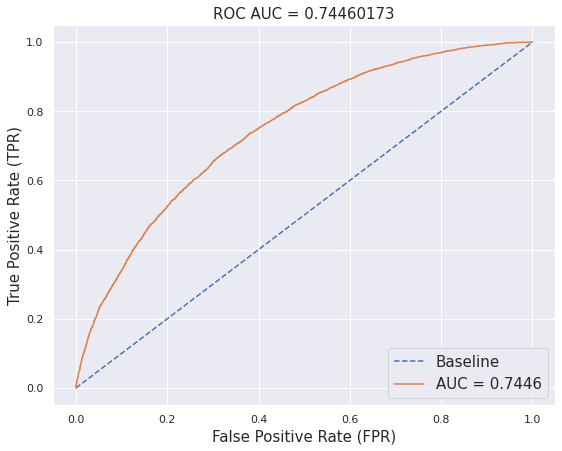

In [46]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 1.6758594914477627e-05,
            "lambda_l2": 1.555459299457268e-07,
            "num_leaves": 8,
            "feature_fraction": 0.4030892028571655,
            "bagging_fraction": 0.7039470678830023,
            "bagging_freq": 3,
            "min_child_samples": 27,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)  # kaggle 0.34004


# final model

In [50]:
# model = LGBMClassifier() # kaggle 0.33657
# model = CatBoostClassifier() # kaggle 0.33794
# model = LogisticRegression(solver='saga', max_iter=1000, random_state=random_seed) # kaggle 0.33933
# model = LGBMClassifier(
#     **{
#         "lambda_l1": 6.636833602368837,
#         "lambda_l2": 0.3221308023736357,
#         "num_leaves": 100,
#         "feature_fraction": 0.4172192685978952,
#         "bagging_fraction": 0.6148275061564304,
#         "bagging_freq": 1,
#         "min_child_samples": 86,
#     }
# )  # kaggle 0.33999
model = LGBMClassifier(
    **{
        "lambda_l1": 1.6758594914477627e-05,
        "lambda_l2": 1.555459299457268e-07,
        "num_leaves": 8,
        "feature_fraction": 0.4030892028571655,
        "bagging_fraction": 0.7039470678830023,
        "bagging_freq": 3,
        "min_child_samples": 27,
    }
)  # kaggle 0.34004

# model.fit(X_us, y_us)
model.fit(X_train_us, y_train_us) # понятия не имею почему, но это ВСЕГДА даёт результаты лучше, чем учить на всём доступном трейне
predict_submission = model.predict(test_data)

[LightGBM] [Warning] bagging_fraction is set=0.7039470678830023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039470678830023
[LightGBM] [Warning] lambda_l1 is set=1.6758594914477627e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6758594914477627e-05
[LightGBM] [Warning] feature_fraction is set=0.4030892028571655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4030892028571655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.555459299457268e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.555459299457268e-07


# submision

In [51]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

In [49]:
# !kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"

# Kaggle score: $0.34004$